In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats.distributions import chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Данные для построения приложены к домашнему заданию (data.csv)

Привет! В этом задании тебе предстоит построить модель для задачи предсказания дефолта клиента. Тебе предоставлен набор признаков и целевая переменная — факт выхода клиентов в просрочку глубины 4 на горизонте 12 месяцев. Нужно провести анализ признаков и выявить наиболее релевантные к задаче, проанализировать их и простроить линейную модель. Этот проект не имеет жестких ограничений на многие пункты и допускает во многом **вольный подход** к его выполнению: например, мы предлагаем самостоятельно выбрать подход к заполнению пропущенных значений и не накладываем никаких ограничений. Таких пунктов в этом проекте много, цель проста: проанализировать то, как ты **самостоятельно** принимаешь решения. Единственное, советуем **аргументировать** свои решения и стараться **интепретировать** полученные результаты, аргументация будет также учтена при оценивании работы.

### Как будет оцениваться ваша работа:
Все пункты (1-12) весят одинаково, итоговая оценка — количество правильно выполненных пунктов. В случае отсутствия аргументации/выводов за пункт ставится 0.5

### Задание
0. Разбейте выборку на train, val, test (обучение и анализ модели проводите на train). Разбиение аналогично тому, что проводилось на семинаре (60/20/20, без шаффла). В случае иного разбиения модель качество модели будет считаться **невалидным**.
1. Исследуйте и  заполните пропуски, **обоснуйте** метод и выскажете свои предположения о возможных причинах их появления
2. Отберите все признаки по ROC-AUC > 0.525
3. Проведите EDA для трёх самых сильных признаков. Как думаете, как **интерпретировать** эти зависимости? (https://en.wikipedia.org/wiki/Exploratory_data_analysis)
4. Постройте матрицу корреляций, удалите все сильные корреляты, поясните свой выбор
5. Настройте градиентный бустинг так, чтобы на тесте качество было не меньше **0.646** (тест никак не должен участвовать в настройке модели) (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
6. Визуализируйте 7 самых сильных признаков по gain (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html) Как думаете, **как работает** самый сильный признак? Почему?(больше -> лучше, меньше -> лучше)
7. Реализуйте функцию **stepwise** для логистической регрессии
8. Отберите признаки с порогами 10 и 15%
9. Обучите логистическую регрессию на признаках, **отобранных** по stepwise
9. Визуализируйте силу признаков линейной модели
10. Сильно ли различается результат по сравнению с бустингом? Как думаете, **почему**?
11. Посчитайте **на тесте** ROC-AUC вашей модели, как считаете, не переобучилась ли она?

### Описание признаков

1. max_util (максимальная утилизация по КК)
2. avg_util (средняя утилизация по КК)
3. credits_2y (количество кредитов за последние 2 года)
4. credits_4y (количество кредитов за последние 4 года)
5. bad_history_credits_flg (наличие кредитов в подозрительных кредитных организациях)
6. other_util (отношение задолженности к сумме кредитов в других организациях)
7. avg_term (средний срок кредита)
8. min_term (минимальный срок кредита)
9. avg_limit_mortgage (средний лимит по ипотекам)
10. min_limit_mfo (минимальный лимит в мфо)
11. close_balance_amt (выплаченная сумма)
12. soc_dem_score (скоринговый балл основанный на соц-дем показателях)
13. max_delq_cnt (максимальное число просрочек по кредиту)
14. avg_active_time (среднее оставшееся время по открытам кредитам)
15. last_credit_time_years (время (в годах) с последнего закрытого кредита)

## Прежде всего взглянем бегло на данные

In [ ]:
df = pd.read_csv('../content/scoring_data.csv')

FileNotFoundError: ignored

In [ ]:
df.head(10)

In [ ]:
df.info()

уже сейчас видны NaN'ы в полях

**Дубликаты**

Лучше удалить их (а они есть) в самом начале

In [ ]:
dup = df[df.duplicated(keep = 'first') == True].index
dup.shape

In [ ]:
df.drop(labels = dup, inplace = True)

In [ ]:
df.shape

А теперь начнём приводить наши "грязные" данные к нормальному, вычещенному виду

## 0. Разбейте выборку на train, val, test (обучение и анализ модели проводите на train).

Разбиение аналогично тому, что проводилось на семинаре (60/20/20, без шаффла). В случае иного разбиения модель качество модели будет считаться невалидным.

In [ ]:
def test_val_split(df, val_size=0.2, test_size=0.2):

    """
        Функция для разбиения выборки на три части по времени (hold-out подход)

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        val_size : str
            размер валидационной выборки
        test_size : str
            размер тестовой выборки

        Returns
        ---
        df : pandas.DataFrame
           исходный датафрейм с новой колонкой sample_part принимающей три значения:
           'train', 'val', 'test'

    """

    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df['d4p12'], test_size=val_size+test_size, shuffle=False)
    df.assign(sample_part='')
    df.loc[X_test.index, 'sample_part'] = 'test'
    X_val, X_test, y_val, y_test = train_test_split(
        df[features][df['sample_part'] == 'test'], df['d4p12'][df['sample_part'] == 'test'],\
        test_size=test_size / (test_size + val_size), shuffle=False)
    df.loc[X_val.index, 'sample_part'] = 'validation'
    df.loc[X_train.index, 'sample_part'] = 'train'
    return df

In [ ]:
df.columns

Выберем фичи и по ходу дела будем их отсеивать.

In [ ]:
features = [
    'max_util',
    'avg_util',
    'credits_2y',
    'credits_4y',
    'bad_history_credits_flg',
    'other_util',
    'avg_term',
    'min_term',
    'avg_limit_mortgage',
    'min_limit_mfo',
    'close_balance_amt',
    'soc_dem_score',
    'max_delq_cnt',
    'avg_active_time',
    'last_credit_time_years'
]

In [ ]:
df = df.sort_values(by=['user_id'])
df = test_val_split(df)

In [ ]:
df.head(10)

In [ ]:
df.user_id.nunique()

In [ ]:
df.bad_history_credits_flg.value_counts()

Смущает второй клиент с аномальным значением **bad_history_credits_flg** (а в прочем, и другие фичи у него сомнительные). Но он такой один и его удаление не помешает.

In [ ]:
df.drop(labels = 222275, inplace = True)

Проверим на адекватность другие признаки

In [ ]:
for i in df:
  print(f"{df[i].value_counts(dropna = False)}\n")

Видим, что в выборке присутствуют некоторые элементы, сильно отличающиеся от от остальных, словом, выбросы. Но мы их оставим, ибо их не так уж и много, а на итоговую модель они повлиюят несущественно.

In [ ]:
def sample_part_distribution(df, date='month_dt', train_nm='train', val_nm='validation', test_nm='test', title='Выборка для построения'):

    """
        Функция для визуализации разбиения категорий в колонке sample_part

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        date : str
            поле по которому будет проводится группировка по времени
        test_nm : str
            название тестовой категории в sample_part
        val_nm : str
            название валидацинной категории в sample_part
        train_nm : str
            название категории для обучения в sample_part
        title : str
            название категории для обучения в sample_part

    """

    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part'] == train_nm])),
            y=df[df['sample_part'] == train_nm].groupby(date).user_id.count(),
            marker_color='indianred', name='train'
        ))
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part'] == val_nm])),
            y=df[df['sample_part']== val_nm].groupby(date).user_id.count(),
             marker_color='lightsalmon', name='validation'
        ))
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part']== test_nm])),
            y=df[df['sample_part']== 'test'].groupby(date).user_id.count(),
            marker_color='lightslategray', name='test'
        ))
    fig.update_layout(barmode='relative', title_text=title)
    fig.show()

In [ ]:
sample_part_distribution(df)

## 1. Исследуйте и заполните пропуски, обоснуйте метод и выскажете свои предположения о возможных причинах их появления

In [ ]:
df.loc[df.sample_part == 'train', :].shape

In [ ]:
df[df.sample_part == 'train'].info()

Под подозрение попадают **avg_term**, **min_term** и **avg_active_time**

In [ ]:
if (df[(df.min_term.isna() == True) & (df.sample_part == 'train')].index == df[(df.avg_term.isna() == True) & (df.sample_part == 'train')].index).all():
  print("Nan в min_term и avg_term на одних и тех же строчках")

In [ ]:
df.loc[(df.sample_part =='train') & (df.avg_term.isna()), :]

В целом природа NaN'ов может быть разной: от умалчиваний клиента до действительных пропусков в заполении полей (как информативных, так и ошибочно проставленных при заполнении алгоритмами). Мы же пока имеем дело с **avg_term** и **min_term** - вероятнее всего не клиенты заполняют эти строки в анкете (минимальный и средний срок кредита), а алгоритм, собирающий информацию из БД и который в этой ситуации мог дать сбой.

In [ ]:
df.loc[(df.sample_part == 'train') & (df.avg_term.isna()), 'bad_history_credits_flg'].mean()

In [ ]:
df.loc[(df.sample_part == 'train') & (df.avg_term.isna()), 'other_util'].mean()

In [ ]:
df.loc[(df.sample_part == 'train') & (df.avg_term.isna()) & (df.bad_history_credits_flg == 1), 'other_util'].mean()

In [ ]:
plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[df.sample_part == 'train'][features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f", cbar = True)
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

Если предположить, что клиенты специально умалчивают и оставляют поля незаполненными, то отметим, что в **min_term** и **avg_term** (которые, очевидно, сильно кореллированы) Nan встречается как у тех, у кого есть кредит в сомнительной организации, так и у тех, у кого нет, почти равновероятно. Конечно, и в поле **bad_history_credits_flg** могут быть ошибки и целиком полагаться на него не стоит. Но может быть и такое, что им нужен кредит для погашения долга в другом месте. Тут всё неоднозначно...

В любом случае я бы заменил **min_term** и **avg_term** со свойством * на среднее значение остальных со свойством *, где свойство * - это:

1. other_util НЕ меньше 1/2 квантили, кредит в сомнительном банке (это условие несколько бесмысленно, но для себя его включу), был кредит за последние 4 года
2. other_util меньше 1/2 квантили, кредит в сомнительном банке, был кредит за последние 4 года
3. other_util НЕ меньше 1/2 квантили, кредит в сомнительном банке, НЕ было кредит за последние 4 года
4. other_util меньше 1/2 квантили, кредит в сомнительном банке, НЕ было кредит за последние 4 года
5. other_util НЕ меньше 1/2 квантили, НЕТ кредита в сомнительном банке
6. other_util меньше 1/2 квантили, НЕТ кредита в сомнительном банке

( Я художник, я так вижу😀 )
На самом деле, кажется, что эти параметры хорошо отобразят суть происходящего и побьют на группы (хотя NaN'ов всего 32 штуки, но мне так захотелось)

### Начнём

In [ ]:
o_u = df.loc[df.avg_term.isna(), 'other_util']
quantile = np.quantile(o_u, 1/2)
quantile

1. other_util НЕ меньше 1/2 квантили, кредит в сомнительном банке, был кредит за последние 4 года

In [ ]:
df.loc[
       (df.sample_part == 'train')      &
       (df.min_term.isna())             &# смотрим по одному min_term, потому что у них с avg_term одинаковые индексы
       (df.other_util >= quantile)      &
       (df.bad_history_credits_flg == 1)&
       (df.credits_4y == 1),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')      &
       (df.min_term.isna() == False)    &
       (df.other_util >= quantile)      &
       (df.bad_history_credits_flg == 1)&
       (df.credits_4y == 1),
       ['min_term', 'avg_term']
       ].mean())

2. other_util меньше 1/2 квантили, кредит в сомнительном банке, был кредит за последние 4 года

In [ ]:
df.loc[
       (df.sample_part == 'train')      &
       (df.min_term.isna())             &
       (df.other_util < quantile)       &
       (df.bad_history_credits_flg == 1)&
       (df.credits_4y == 1),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')       &
       (df.min_term.isna() == False)     &
       (df.other_util < quantile)        &
       (df.bad_history_credits_flg == 1) &
       (df.credits_4y == 1),
       ['min_term', 'avg_term']
       ].mean())

3. other_util НЕ меньше 1/2 квантили, кредит в сомнительном банке, НЕ было кредит за последние 4 года

In [ ]:
df.loc[
       (df.sample_part == 'train')        &
       (df.min_term.isna())               &
       (df.other_util >= quantile)        &
       (df.bad_history_credits_flg == 1)  &
       (df.credits_4y == 0),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')        &
       (df.min_term.isna() == False)      &
       (df.other_util >= quantile)        &
       (df.bad_history_credits_flg == 1)  &
       (df.credits_4y == 0),
       ['min_term', 'avg_term']
       ].mean())

4. other_util меньше 1/2 квантили, кредит в сомнительном банке, НЕ было кредит за последние 4 года

In [ ]:
df.loc[
       (df.sample_part == 'train')       &
       (df.min_term.isna())              &
       (df.other_util < quantile)        &
       (df.bad_history_credits_flg == 1) &
       (df.credits_4y == 0),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')       &
       (df.min_term.isna() == False)     &
       (df.other_util < quantile)        &
       (df.bad_history_credits_flg == 1) &
       (df.credits_4y == 0),
       ['min_term', 'avg_term']
       ].mean())

5. other_util НЕ меньше 1/2 квантили, НЕТ кредита в сомнительном банке

In [ ]:
df.loc[
       (df.sample_part == 'train')       &
       (df.min_term.isna())              &
       (df.other_util >= quantile)       &
       (df.bad_history_credits_flg == 0),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')        &
       (df.min_term.isna() == False)      &
       (df.other_util >= quantile)        &
       (df.bad_history_credits_flg == 0),
       ['min_term', 'avg_term']
       ].mean())

6. other_util меньше 1/2 квантили, НЕТ кредита в сомнительном банке

In [ ]:
df.loc[
       (df.sample_part == 'train')        &
       (df.min_term.isna())               &
       (df.other_util < quantile)         &
       (df.bad_history_credits_flg == 0),
       ['min_term', 'avg_term']

       ]=np.array(
        df.loc[

       (df.sample_part == 'train')        &
       (df.min_term.isna() == False)      &
       (df.other_util < quantile)         &
       (df.bad_history_credits_flg == 0),
       ['min_term', 'avg_term']
       ].mean())

P.S. fillna() выдаёт известную ошибку SettingWithCopyWarning, поэтому так колхозно и сделал. Скорее всего, есть более красивый и простой метод.

Убедимся, что не осталось NaN в полях **min_term** и **avg_term**

In [ ]:
df.loc[(df.sample_part =='train') & (df.min_term.isna()), :]

In [ ]:
df.loc[(df.sample_part =='train') & (df.avg_term.isna()), :]

Теперь устраним NaN в поле **avg_active_time** - среднее оставшееся время по открытам кредитам

In [ ]:
df.loc[df.sample_part == 'train', 'avg_active_time'].mean()

То есть в среднем 11 лет людям ещё платить и платить

In [ ]:
df.loc[(df.sample_part == 'train') & (df.avg_active_time.isna()), :]

Тут же NaN'ов достаточно много

In [ ]:
df.loc[(df.sample_part == 'train') & (df.avg_active_time.isna()), 'bad_history_credits_flg'].mean()

Тут уже кажется, что клиент может намеренно скрыть информацию, ведь большинство из них имеют кредит в сомнительных организациях

In [ ]:
quantile_ou = np.quantile(df.loc[(df.sample_part == 'train') & (df.avg_active_time.notna()), 'other_util'], 1/2)
quantile_ou

In [ ]:
quantile_lcty = np.quantile(df.loc[(df.sample_part == 'train') & (df.avg_active_time.notna()) & (df.last_credit_time_years != 0), 'last_credit_time_years'], 1/2)
quantile_lcty

Разрубим выборку на 4 части 2мя уровнями квантилей **other_util** и **last_credit_time_years** и среди них изменим NaN. Кажется, эти характеристики могут рассказать о платёжеспособности и честности клиента (хотя у этого признака со всеми корреляция низкая)

In [ ]:
df.loc[
       (df.sample_part == 'train')                 &
       (df.avg_active_time.isna())                 &
       (df.other_util < quantile_ou)               &
       (df.last_credit_time_years < quantile_lcty),
       'avg_active_time'

       ]= df.loc[

       (df.sample_part == 'train')                 &
       (df.min_term.isna() == False)               &
       (df.other_util < quantile_ou)               &
       (df.last_credit_time_years < quantile_lcty),
       'avg_active_time'
       ].mean()

In [ ]:
df.loc[
       (df.sample_part == 'train')                 &
       (df.avg_active_time.isna())                 &
       (df.other_util < quantile_ou)               &
       (df.last_credit_time_years >= quantile_lcty),
       'avg_active_time'

       ]=df.loc[

       (df.sample_part == 'train')                 &
       (df.min_term.isna() == False)               &
       (df.other_util < quantile_ou)               &
       (df.last_credit_time_years >= quantile_lcty),
       'avg_active_time'
       ].mean()

In [ ]:
df.loc[
       (df.sample_part == 'train')                  &
       (df.avg_active_time.isna())                  &
       (df.other_util >= quantile_ou)               &
       (df.last_credit_time_years < quantile_lcty),
       'avg_active_time'

       ]=df.loc[

       (df.sample_part == 'train')                  &
       (df.min_term.isna() == False)                &
       (df.other_util >= quantile_ou)               &
       (df.last_credit_time_years < quantile_lcty),
       'avg_active_time'
       ].mean()

In [ ]:
df.loc[
       (df.sample_part == 'train')                  &
       (df.avg_active_time.isna())                  &
       (df.other_util >= quantile_ou)               &
       (df.last_credit_time_years >= quantile_lcty),
       'avg_active_time'

       ]=df.loc[

       (df.sample_part == 'train')                  &
       (df.min_term.isna() == False)                &
       (df.other_util >= quantile_ou)               &
       (df.last_credit_time_years >= quantile_lcty),
       'avg_active_time'
       ].mean()

Убедимся, что не осталось NaN в поле **avg_active_time**

In [ ]:
df.loc[(df.sample_part =='train') & (df.avg_active_time.isna()), :]

И в целом

In [ ]:
df.loc[df.sample_part == 'train',:].isna().sum()

И ещё для 11ого задания требуется обойтись без NaN, так что удалим их и в валидации и тесте, но не так эстетично. А вообще, как я понимаю, это делать можно только в трейне и валидации.

In [ ]:
df.dropna(inplace = True)

И проверим, что с размарами всё хорошо (было (133364, 19) )

In [ ]:
df.loc[df.sample_part == 'train', :].shape

Теперь ограничим отрицательные **avg_term** и **min_term**  в трейне и валидации нулём, хотя уверен, что можно более аккуратно заменить, так же смотря на зависимости с другими признаками.

In [ ]:
df.loc[(df.avg_term < 0) & (df.sample_part == 'train') & (df.sample_part == 'validation'), 'avg_term'] = 0
df.loc[(df.min_term < 0) & (df.sample_part == 'train') & (df.sample_part == 'validation'), 'min_term'] = 0

## 2. Отберите все признаки по ROC-AUC > 0.525

In [ ]:
def filter_by_score(df, features=None, target='d4p12', score=roc_auc_score, greater_is_better=True, top_n=10):

    """
        Функция для фильтрации признаков по заданной метрике качества

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        features : str
            список переменных для фильтрации
        target : str
            целевая переменная
        score : func
            функция формата func(y_true, y_pred) по которой будут отбираться признаки
            по умолчанию используется sklearn.metrics.roc_auc_score
        greater_is_better: bool
            если ваша метрика — score (больше -> лучше), тогда True, если loss (меньше -> лучше),
            используйте False
        top_n : int
            количество самых лучших признаков с точки зрения метрики

        Returns
        ---
        object : pandas.Series
           Series с top_n лучшими признаками с точки зрения score

    """
    if not features:
        features = set(df.select_dtypes(include=['float64']).columns)
    metrics = {}
    for feature in features:
        mask = (df[target].notna()) & (df[feature].notna())
        metrics[feature] = max(roc_auc_score(df[target][mask], df[feature][mask]), 1-roc_auc_score(df[target][mask], df[feature][mask]))
    if greater_is_better:
        return pd.Series(metrics).sort_values(ascending=False).head(n=top_n)
    return pd.Series(metrics).sort_values(ascending=True).head(n=top_n)

In [ ]:
top_roc = filter_by_score(df[df['sample_part'] == 'train'], features, top_n=15)

In [ ]:
top_name = top_roc[top_roc > 0.525].axes[0]
features = top_name
features

Index(['max_util', 'last_credit_time_years', 'soc_dem_score', 'avg_util',
       'other_util', 'credits_4y', 'credits_2y', 'min_limit_mfo',
       'close_balance_amt', 'avg_limit_mortgage', 'avg_active_time'],
      dtype='object')

## 3. Проведите EDA для трёх самых сильных признаков.
Как думаете, как интерпретировать эти зависимости? (https://en.wikipedia.org/wiki/Exploratory_data_analysis)

In [ ]:
def EDA (df, features, n = 3):

  sns.set_style('darkgrid')
  for i in features[:n]:
    for j in features[n:]:

        plt.figure(figsize=(12, 8))
        plt.xlabel(i,size=12)
        plt.ylabel(j,size=12)
        sns.scatterplot(x=i, y=j, data=df, edgecolor='black', palette='cubehelix')
        plt.show()

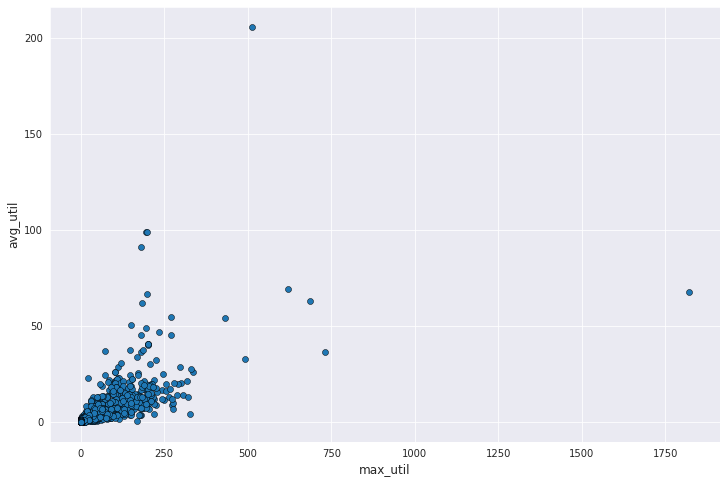

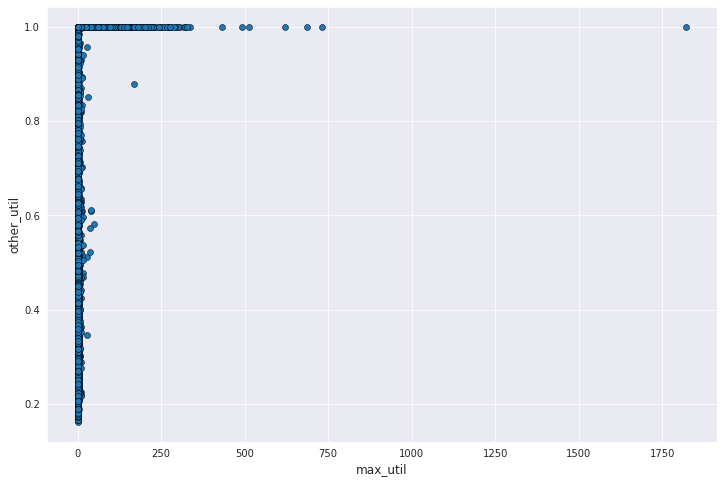

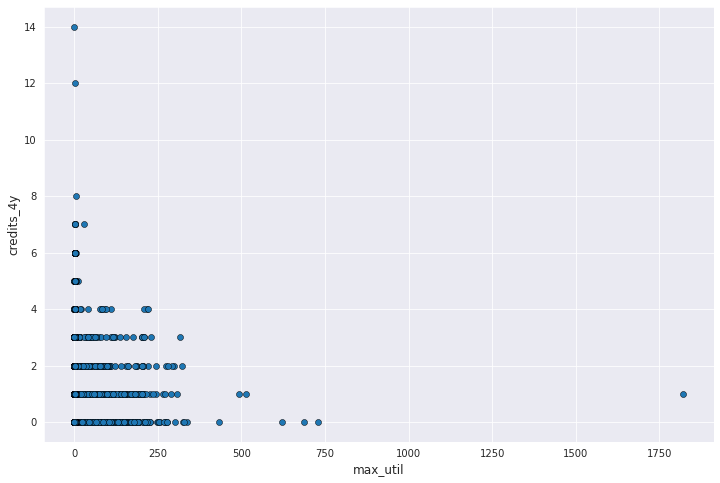

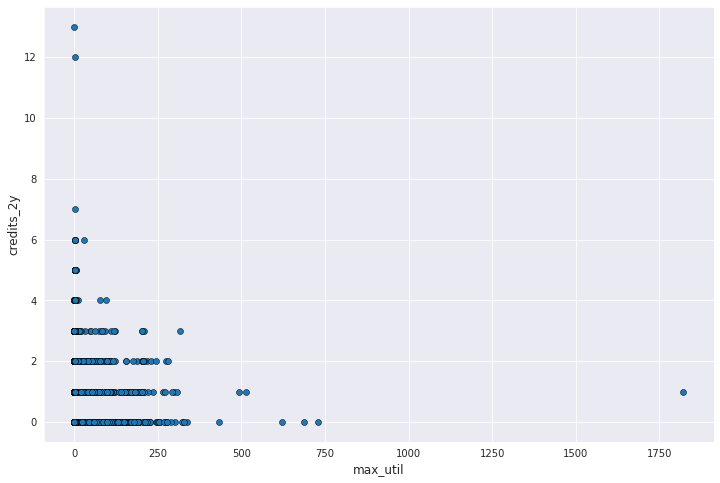

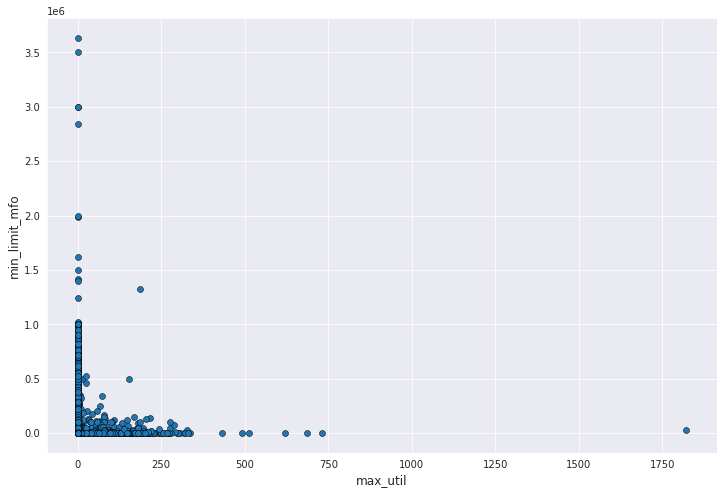

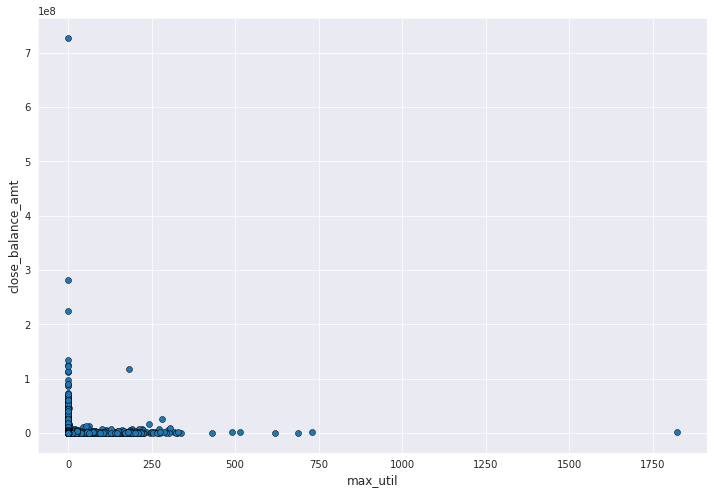

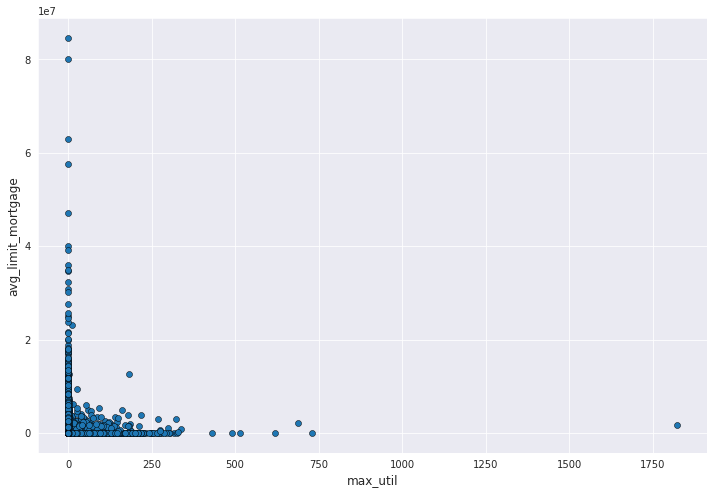

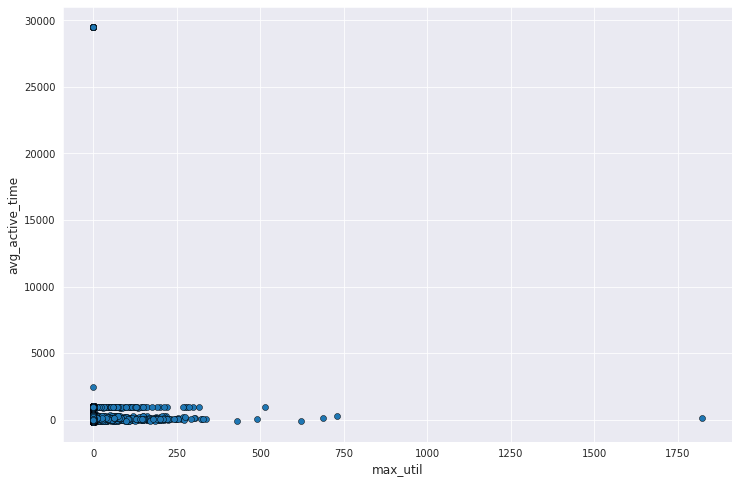

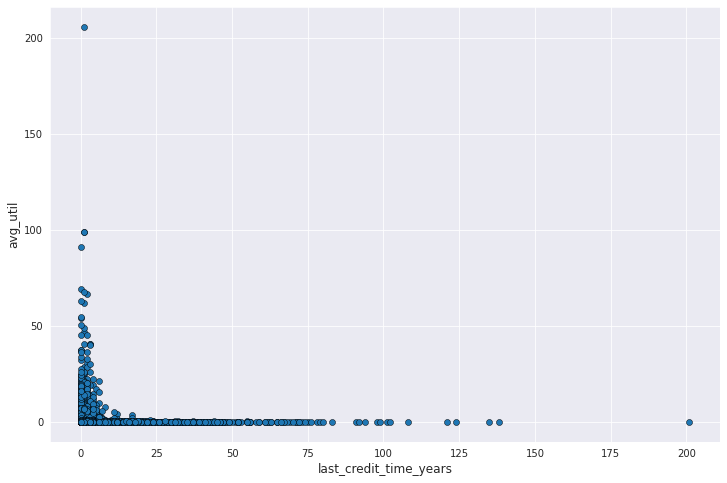

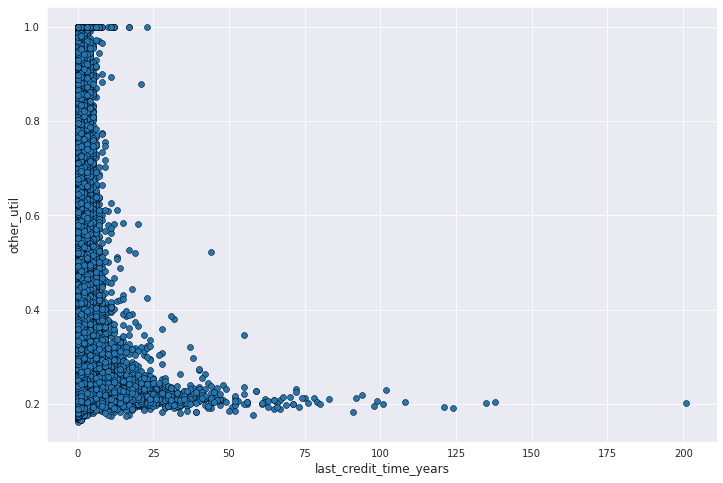

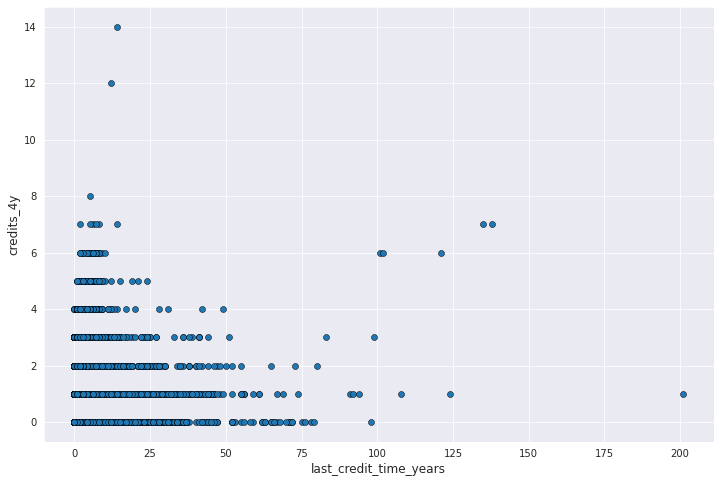

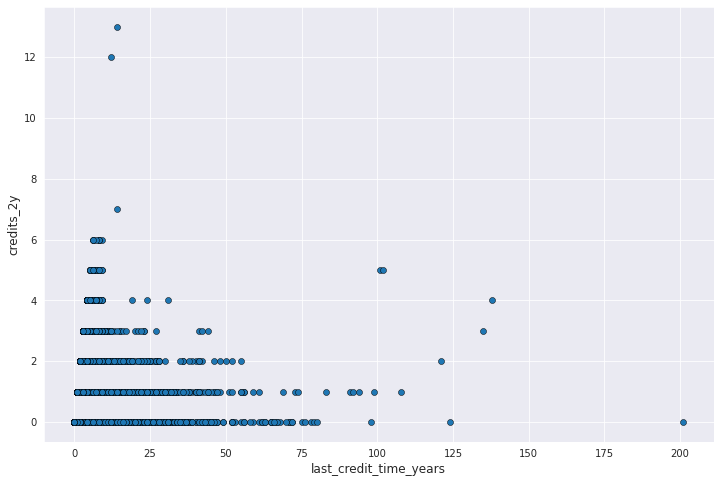

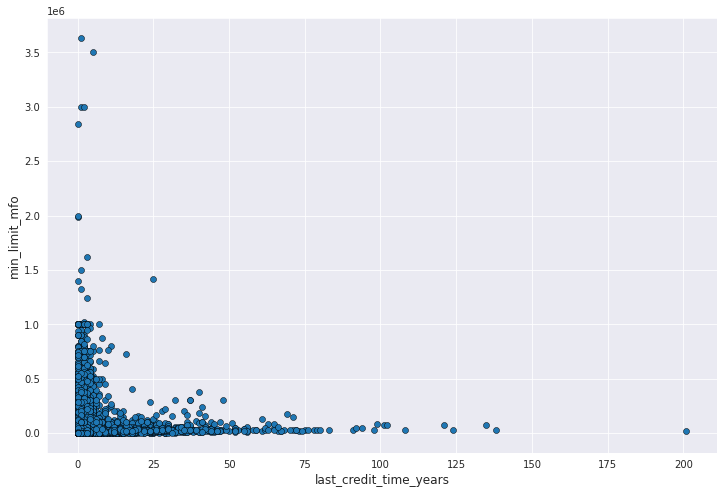

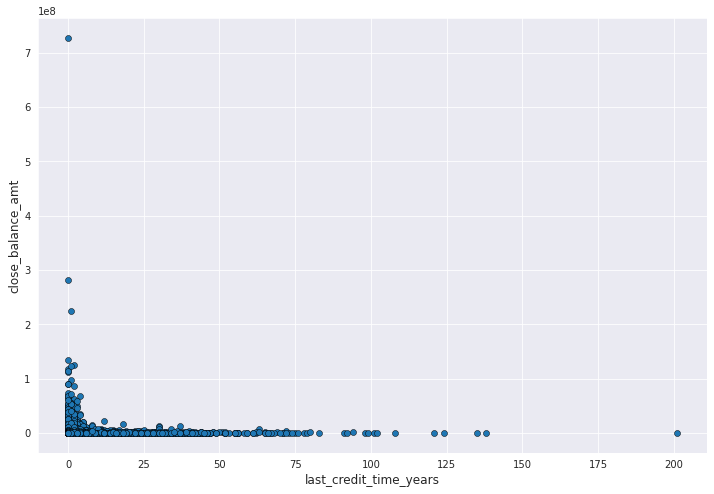

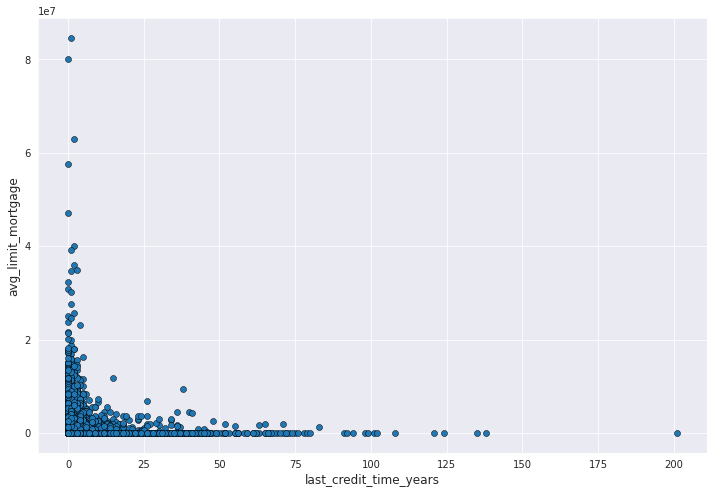

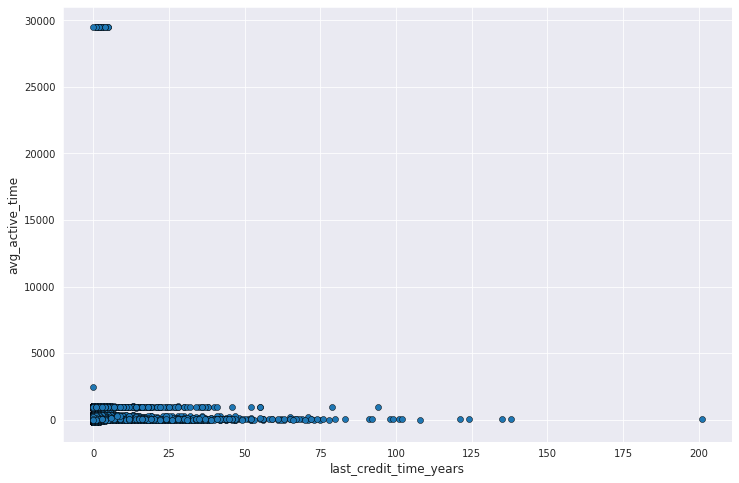

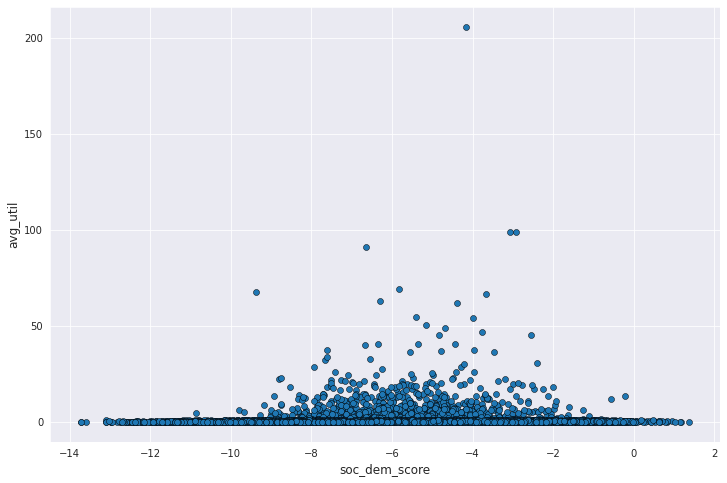

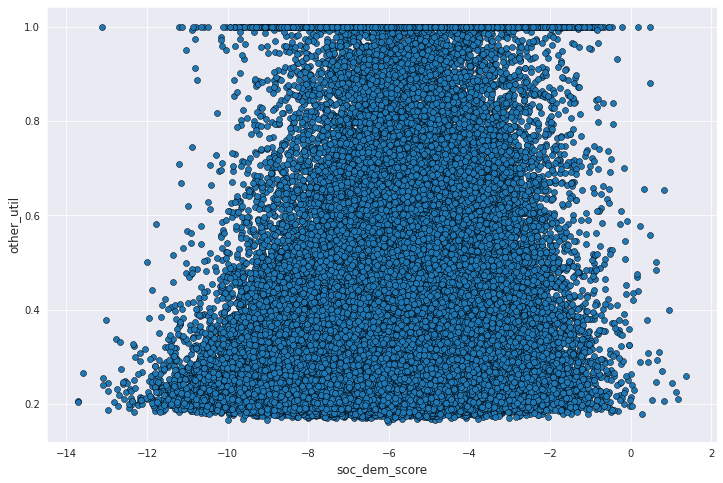

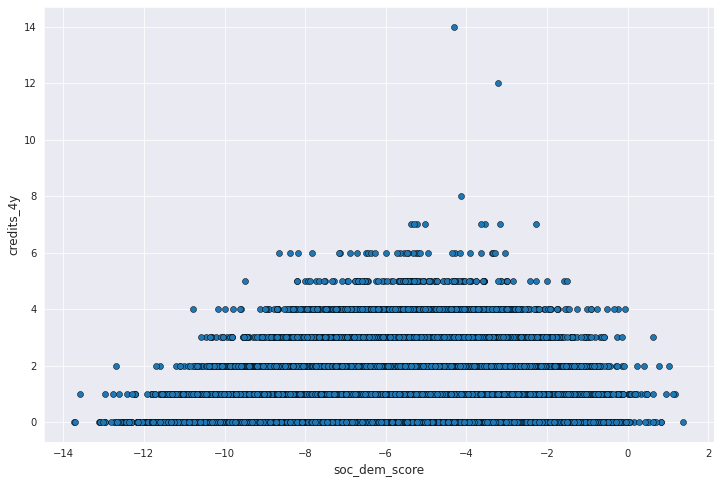

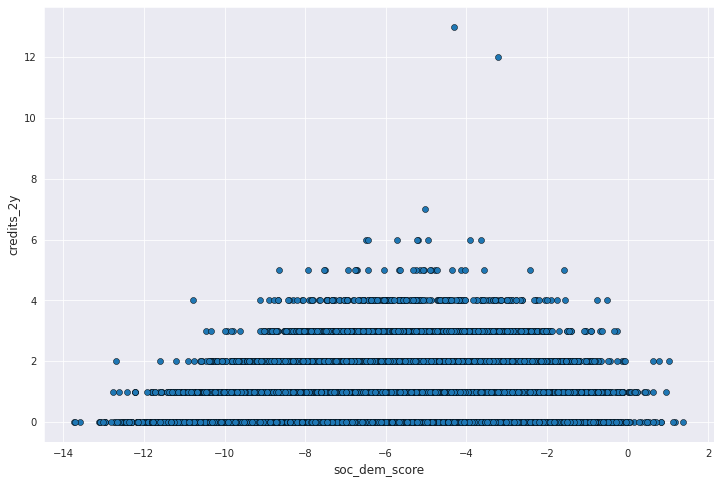

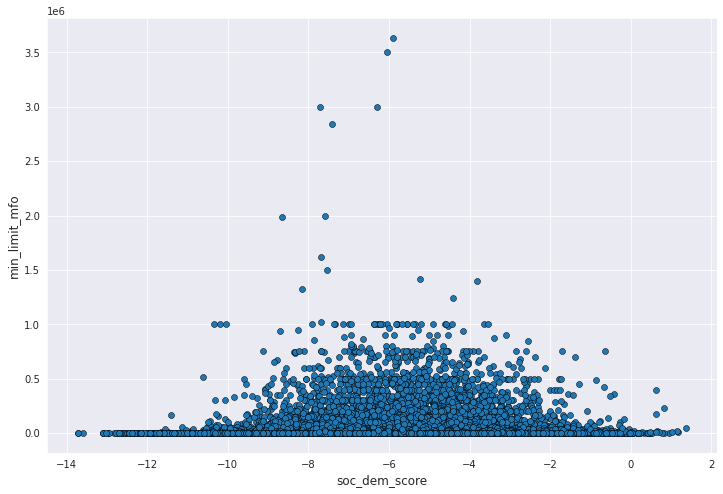

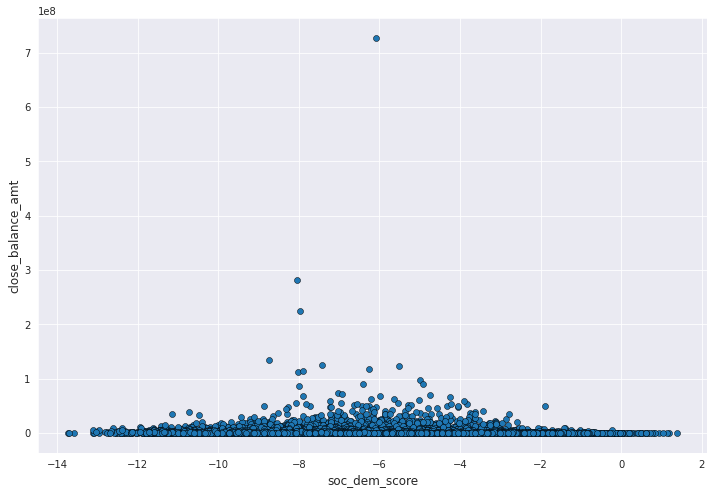

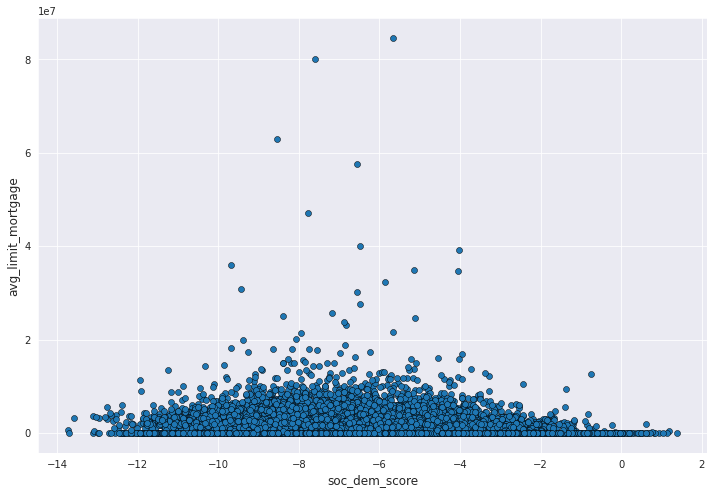

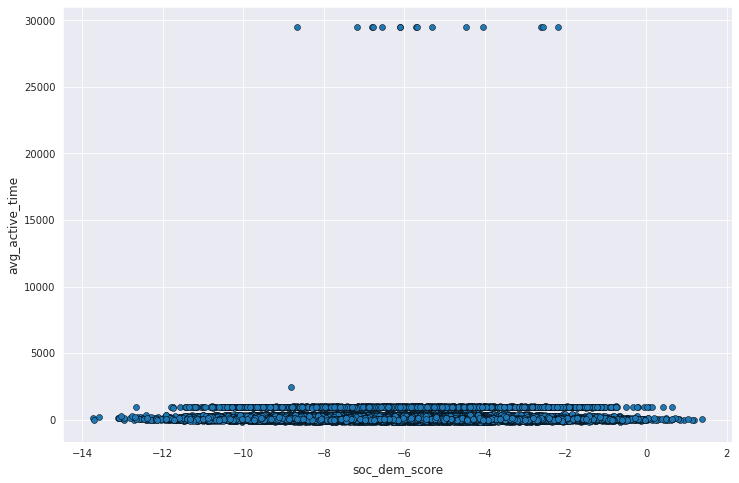

In [ ]:
EDA(df.loc[df.sample_part == 'train', :], features, 3)

EDA необходима для оценки 'на глаз' зависимостей между параметрами. Тут же можно и удалять выбросы.

Некоторые зависимости показались мне неявными и неинтерпретируемыми. На других же можно заметить какую-то тенденцию, например треугольно-образное, г-образное скопление.

Рассмотрим эти зависимости ближе

In [ ]:
def EDA_uni (df, feature_1, feature_2):

  plt.figure(figsize=(12, 8))
  plt.xlabel(feature_1,size=12)
  plt.ylabel(feature_2,size=12)
  sns.scatterplot(x=feature_1, y=feature_2, data=df, edgecolor='black', palette='cubehelix')
  plt.show()

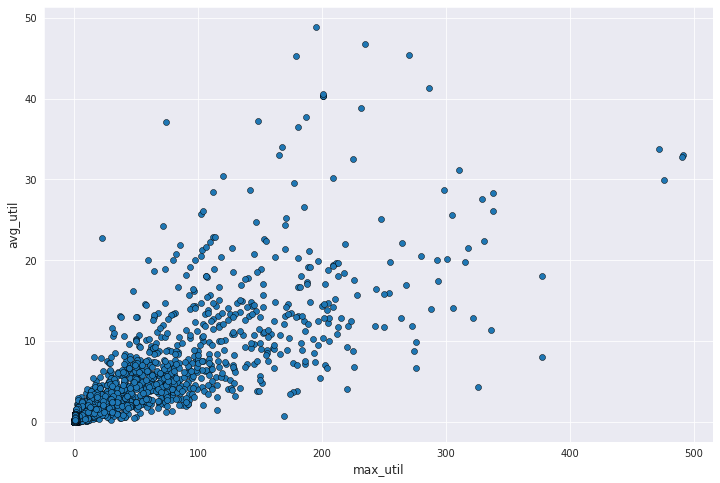

In [ ]:
EDA_uni(df.loc[(df.avg_util < 50) & (df.max_util < 500), : ], 'max_util', 'avg_util')

Тут заметно увеличение дисперсии значения **avg_util** с ростом **max_util** (отсутствует гомоскедастичность, если можно так выразиться)

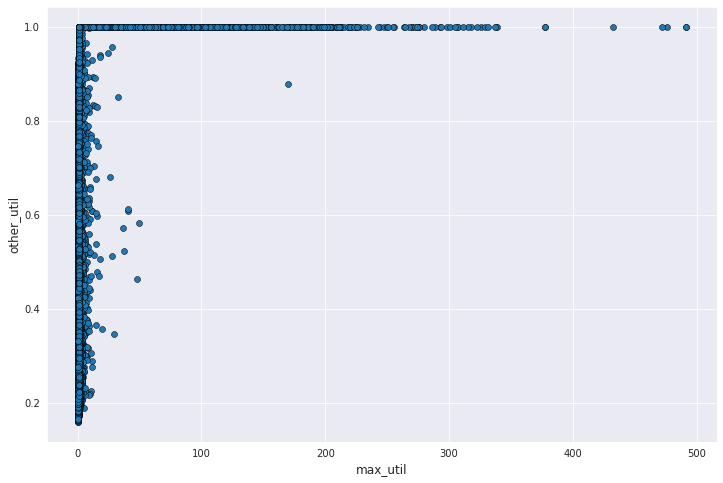

In [ ]:
EDA_uni(df.loc[(df.max_util < 500), : ], 'max_util', 'other_util')

В целом ожидаемо, как и в остальных г-образных зависимостях

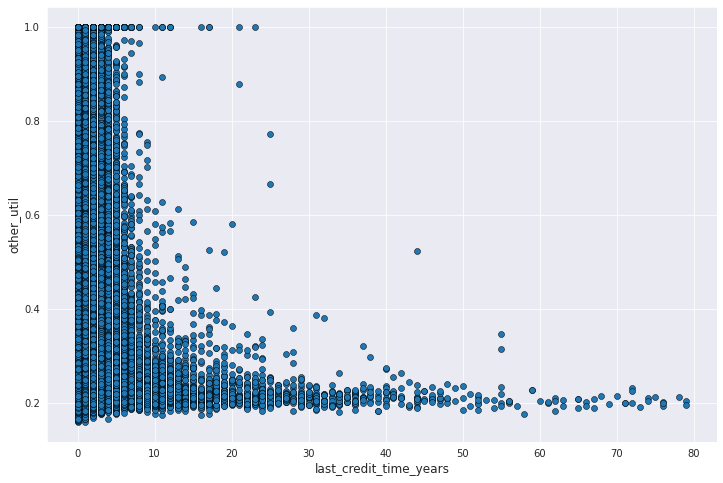

In [ ]:
EDA_uni(df.loc[df.last_credit_time_years < 80, :], 'last_credit_time_years', 'other_util')

Довольно понятная и интересная зависимость: чем больше времени прошло с момента последнего кредита, тем меньше задолжность. То есть начиная с ~10 лет от момента закрытия кредита люди имеют заметно меньшую задолжность по кредитам

## 4. Постройте матрицу корреляций, удалите все сильные корреляты, поясните свой выбор

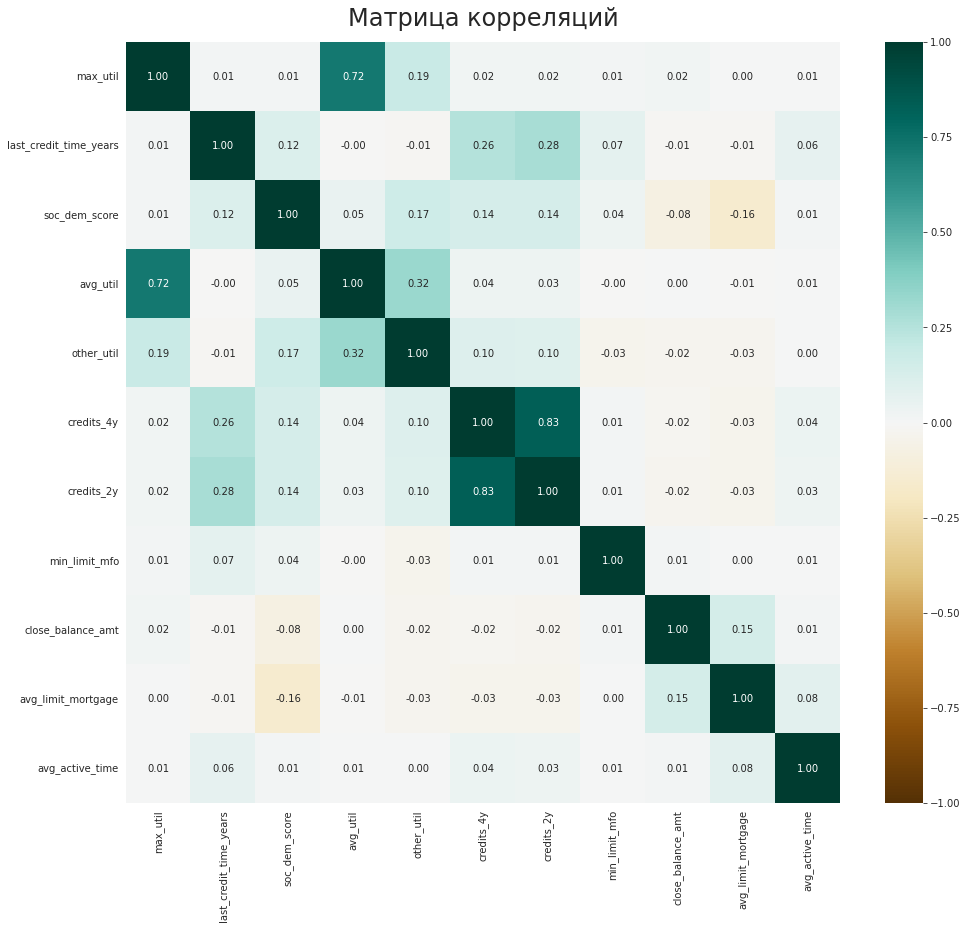

In [ ]:
plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[df.sample_part == 'train'][features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

Имеет смысл избавиться от **credits_2y**, ведь с **credits_4y** он имеет высокую корреляцию (0.83), но при этом в топе (top_names он же features)находится ниже. Не имеет смысла оставлять два схожих признака, они несут примерно одинаковую информацию.
Аналогично стоит избавиться и от **avg_util** - его "двойник" по информативности **max_util**.

In [ ]:
features = list(features)

features.remove('credits_2y')
features.remove('avg_util')
features

['max_util',
 'last_credit_time_years',
 'soc_dem_score',
 'other_util',
 'credits_4y',
 'min_limit_mfo',
 'close_balance_amt',
 'avg_limit_mortgage',
 'avg_active_time']

## 5. Настройте градиентный бустинг так, чтобы на тесте качество было не меньше 0.646
(тест никак не должен участвовать в настройке модели) (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [ ]:
X_train = df[features][df['sample_part'] == 'train']
y_train = df['d4p12'][df['sample_part'] == 'train']

X_val   = df[features][df['sample_part'] == 'validation']
y_val   = df['d4p12'][df['sample_part'] == 'validation']

X_test  = df[features][df['sample_part'] == 'test']
y_test  = df['d4p12'][df['sample_part'] == 'test']

In [ ]:
grid_params = {'num_leaves': [13, 14, 15], 'max_depth': [5, 6, 7], 'n_estimators': [102, 105], 'learning_rate': [0.08, 0.09, 0.1]}

model = LGBMClassifier()
clf   = GridSearchCV(model, grid_params, n_jobs = -1)

clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf = clf.best_estimator_

In [ ]:
pred_train = clf.predict_proba(X_train)[:, 1]
round(roc_auc_score(y_train, pred_train), 3)

In [ ]:
pred_val = clf.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, pred_val), 3)

Чуть-чуть подкрутим параметры, которые нам выдал GridSearch, (смотрим на валидацию и трейн) и вуа-ля

In [ ]:
clf = LGBMClassifier(learning_rate = 0.11, max_depth = 5, n_estimators = 98, num_leaves= 15)
clf.fit(X_train, y_train)

In [ ]:
pred_train = clf.predict_proba(X_train)[:, 1]
round(roc_auc_score(y_train, pred_train), 3)

In [ ]:
pred_val = clf.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, pred_val), 3)

Ну ладно, валидация слегка уменьшилась, но хотя бы тест хороший.

In [ ]:
pred_test = clf.predict_proba(X_test)[:, 1]
round(roc_auc_score(y_test, pred_test), 3)

Итого: clf - наша обученная моделька

## 6.Визуализируйте 7 самых сильных признаков по gain
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

Как думаете, как работает самый сильный признак? Почему?(больше -> лучше, меньше -> лучше)

In [ ]:
plot_importance(clf, importance_type='gain', max_num_features=7, figsize=(20, 20), precision=3)
plt.show()

Тут мы используем подход gain, который в отличае от split считает не количество вхождений признака в узлы ансабля, а уменьшение неопределённости при разбиении по признаку, выгоду от разбиения по признаку. Кажется, что это должно быть схоже с feature_importance для деревьев.

Выходит, что от признака **max_util** - отношение максимальной задолжности к лимиту по кредитной карте - зависимость результата наибольшая. Скорее всего этот признак находится наверху деревьев в начале, и именно максимальная утилизация по КК лучше прогнозирует вероятность выпадения в дефол.

In [ ]:
np.corrcoef(df['max_util'], df['d4p12'])

In [ ]:
print(f'границы признака max_util: { df["max_util"].min(), df["max_util"].max()}')

In [ ]:
np.quantile(df['max_util'], 1/2), np.quantile(df['max_util'], 3/4), np.quantile(df['max_util'], 9/10)

Конечно, хочется сказать, зависимость должна быть прямой, ведь логично, что чем больше максимальная утилизация по КК, то есть чем больше денег задолжал клиент сверх лимита, тем больше вероятность выпадения его в дефолт.

## 7. Реализуйте функцию stepwise для логистической регрессии


In [ ]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия "короткой" модели
    ll_long — логарифм правдоподобия "длинной" модели

    Returns
    -----
    p-value
    """
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def stepwise_selection(df, features, target='d4p12', alpha_in= 0.1, alpha_out= 0.15):

    """
    Функция для отбора признаков в соответствии с их вкладом в общую модель

    Parameters
    ----------
    df : DataFrame
        датафрейм с наблюдениями и целевой переменной
    features : list
        список рассматриваемых признаков
    target : int
        размер тестовой выборки
    alpha_in: float
        порог входа
    alpha_out: float
        порог выхода

    Returns
    ---
    selected_features : list
        список переменных отобранных на заданном уровне значимости alpha
    """

    selected_features = list()
    n = len(features)
    p_value = 1
    while len(selected_features) < n:

        potential_features = list(set(features) - set(selected_features))
        best_feature = ''

        for feature in potential_features:

            temp_features = [feature] + selected_features

            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long  = LogisticRegression(penalty='none', max_iter=500)

            if len(selected_features) == 0: #первый шаг

                const = pd.Series([1]*df.shape[0])

                lr_short.fit(np.array(const).reshape(-1, 1), df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False)

                lr_long.fit(np.array(df[temp_features]).reshape(-1, 1), df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[temp_features]).reshape(-1, 1))[:, 1], normalize=False)

            else: #на 2ом и тд шагах

                lr_short.fit(df[selected_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[selected_features])[:, 1], normalize=False)

                lr_long.fit(df[temp_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[temp_features])[:, 1], normalize=False)

            if likelihood_ratio_test(ll_short, ll_long) < alpha_in and likelihood_ratio_test(ll_short, ll_long) < p_value:

                p_value = likelihood_ratio_test(ll_short, ll_long)
                best_feature = feature

        if best_feature == '': break

        selected_features.append(best_feature)
        print(f"В модель была добавлена переменная {best_feature}, p-value: {p_value}")
        p_value = 1

        if len(selected_features) > 1 :


            feature_to_drop = ''
            for feature in selected_features:

                temp_features = list(set(selected_features) - set(feature))

                lr_short = LogisticRegression(penalty='none', max_iter=500)
                lr_long  = LogisticRegression(penalty='none', max_iter=500)


                lr_long.fit(df[selected_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[selected_features])[:, 1], normalize=False)

                lr_short.fit(df[temp_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[temp_features])[:, 1], normalize=False)

                if likelihood_ratio_test(ll_short, ll_long) > alpha_out and likelihood_ratio_test(ll_short, ll_long) > p_value:

                    p_value = likelihood_ratio_test(ll_short, ll_long)
                    feature_to_drop = feature


            if feature_to_drop != '':
              selected_features.remove(feature_to_drop)
              print(f"Из модели была выкинута переменная {feature_to_drop}, p-value: {p_value}")
              p_value = 0

    return selected_features

## 8. Отберите признаки с порогами 10 и 15%

In [ ]:
features_log = stepwise_selection(df.loc[df.sample_part == 'train', :], features, target='d4p12', alpha_in= 0.1, alpha_out= 0.15)

## 9. Обучите логистическую регрессию на признаках, отобранных по stepwise


In [ ]:
logreg = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500)

X_train = df.loc[df.sample_part == 'train', features_log]
logreg.fit(X_train, y_train)

## 10. Визуализируйте силу признаков линейной модели


In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', logreg)])
pipe.fit(df[features_log][df['sample_part'] == 'train'],\
         df['d4p12'][df['sample_part'] == 'train'])

In [ ]:
df['logreg_predict'] = pipe.predict_proba(df[features_log])[:, 1]

In [ ]:
coef = pd.DataFrame(pipe.get_params()['model'].coef_[0],index=features_log, columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'])
plot.figure.set_size_inches(20, 16)

## 11. Сильно ли различается результат по сравнению с бустингом? Как думаете, почему?

Напомним список призаков в бустинге:

In [ ]:
plot_importance(clf, importance_type='gain', max_num_features=7, figsize=(20, 20), precision=3)
plt.show()

Не все признаки вошли в итоговый список, а те, что вошли, даже поменяли свои взаимозависимости. Скорее это связано с особенностями подхода каждой из модели - бустинга над деревьями и логрега. В этой ситуации бустинг показал себя лучше (незначительно, но лучше), о чем говорит задание 12, да и в целом он эффективнее.

(в общем случае не стоит думать, что признаки, которые оказались ниже, менее информативны, может быть и такое, что они просто несут одну и ту же информацию и дерево отнесло их на разные уровни, но мы для этого уберали коррелянты).

Ещё хочу добавить, что в линейных моделях знак коэффициента значимости может говорить о принятии положительного или отрицательного исхода, в то время как значимости признаков в деревьях всегда положительны и по ним мы не можем сказать об исходе. Можем только утверждать, что они значимы, но вот в какую сторону - не ясно. К слову, это можно увидеть, если показать значимость ВСЕХ признаков для линейной модели, там avg_limit_mortage будет сильно отрицательным.

## 12. Посчитайте на тесте ROC-AUC вашей модели, как считаете, не переобучилась ли она?

In [ ]:
df['gb_predict'] = clf.predict_proba(df[features])[:, 1]

In [ ]:
print(f"Значение ROC-AUC на тесте у линейной модели:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], df['logreg_predict'][df['sample_part'] == 'test']), 3)}")

print(f"Значение ROC-AUC на тесте у бустинга:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], df['gb_predict'][df['sample_part'] == 'test']), 3)}")

In [ ]:
print(f"Значение ROC-AUC на трейне у линейной модели:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], df['logreg_predict'][df['sample_part'] == 'train']), 3)}")

print(f"Значение ROC-AUC на трейне у бустинга:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], df['gb_predict'][df['sample_part'] == 'train']), 3)}")

Нет, ни *недообучения*, ни *переобучения* не выявлено.

### Чек лист готовности работы ('x' чтобы поставить галочку)

- [x]  Признаки отобраны по ROC-AUC
- [x]  EDA проведён
- [x]  Корреляты удалены
- [x]  Градиентный бустинг обучен и достигает нужного качества
- [x]  Самые сильные признаки отобраны
- [x]  Stepwise реализован
- [x]  Линейная модель обучена, проанализирована сила признаков
- [x]  Метрики на тесте посчитаны
- [x]  Проведено сравнение качества моделей, выдвинуты гипотезы о причинах наблюдаемых результатов

In [ ]:
import pickle

pkl_filename = "pickle_model.pkl"

with open(pkl_filename, 'wb') as file:
  pickle_model = pickle.dump(clf, file)